# Validation Service Benchmarks


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

### Configuration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


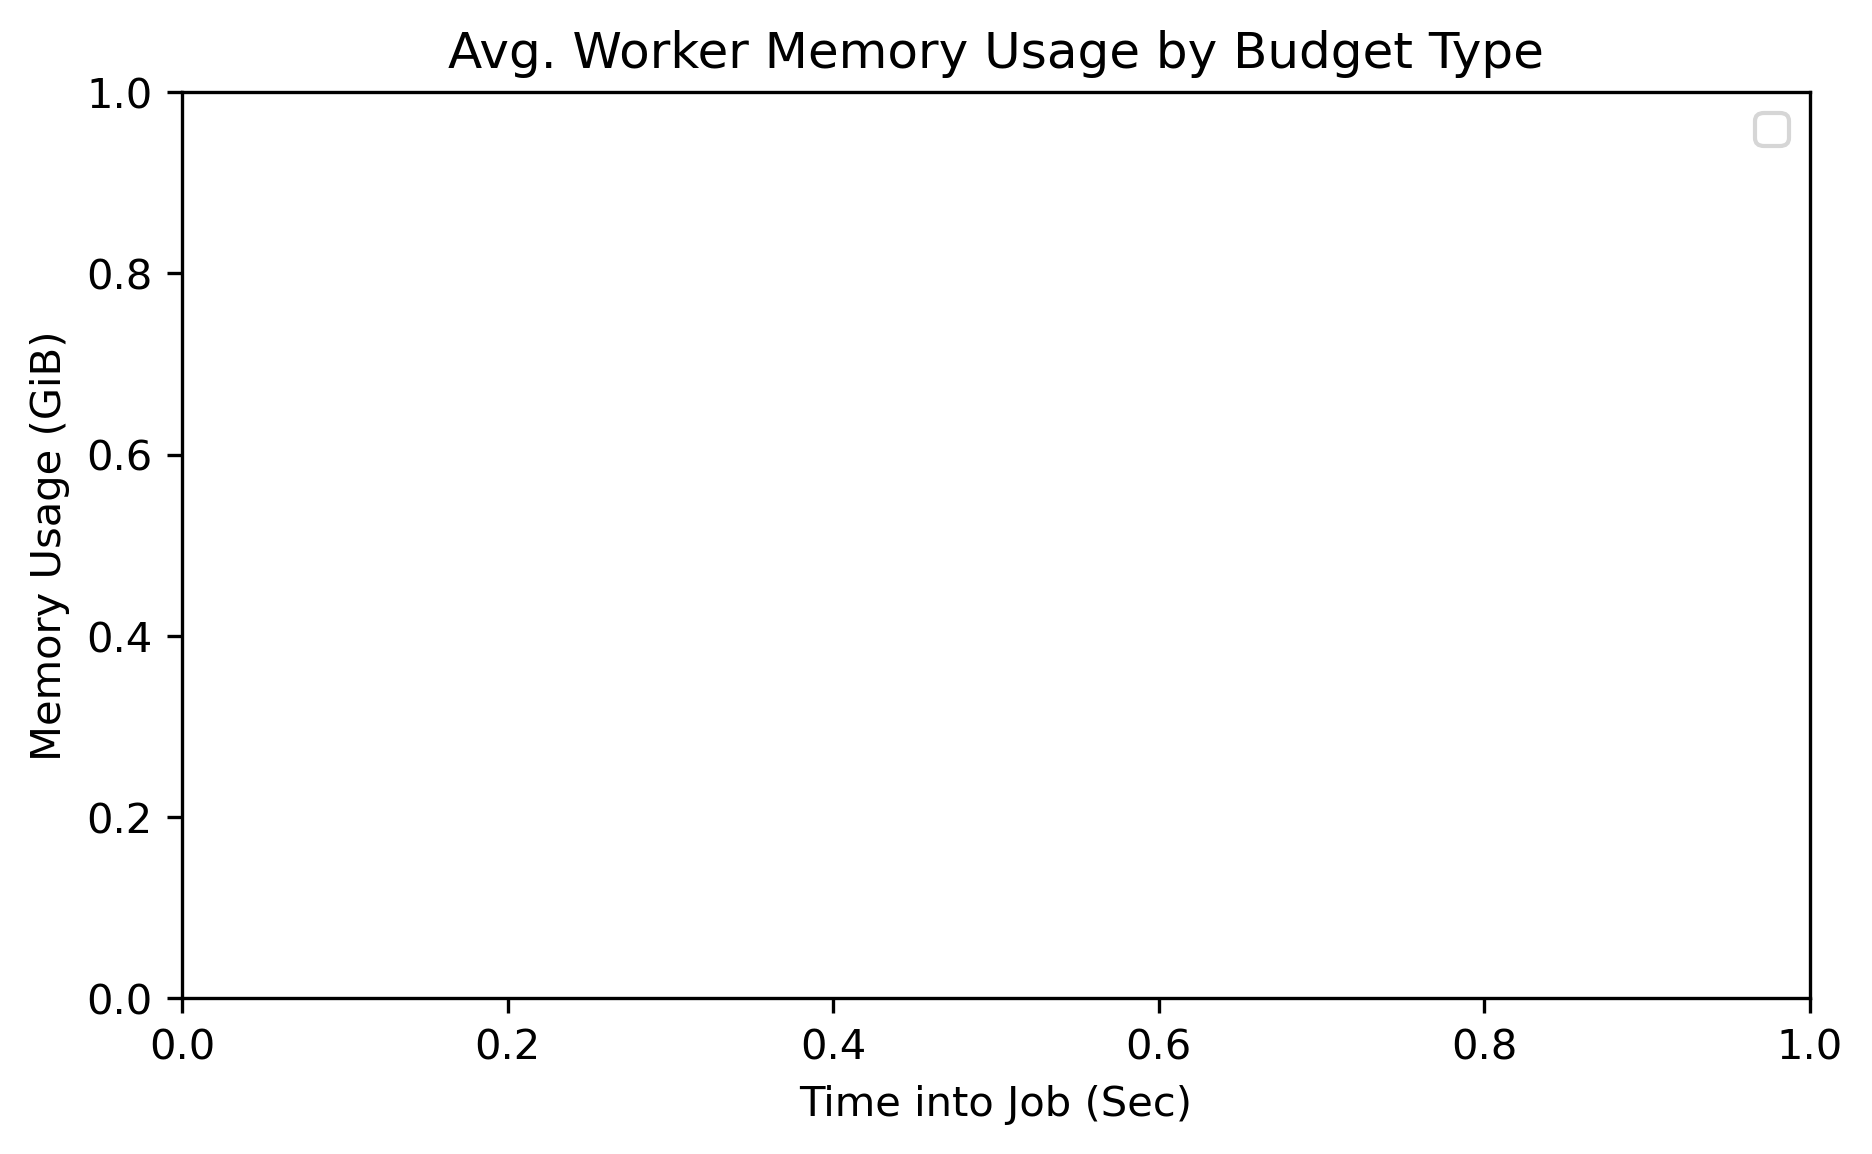

In [6]:
nmon_metric_options = [
    ("timestamp", "Timestamp MS since Epoch", [0, 80], "timestamp"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100], "cpu_all_user_percent"), # 1
    ("CPU_ALL:Sys%", "CPU Total: System %", [0,100], "cpu_all_system_percent"), # 2
    ("MEM:memtotal", "Memory MB: Total", [0,65000], "mem_MB_total"), #3
    ("MEM:hightotal", "Memory MB: High Total", [0,65000], "mem_MB_high_total"), #4
    ("MEM:lowtotal", "Memory MB: Low Total", [0,65000], "mem_MB_low_total"), #5
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000], "mem_MB_swap_free"), #6
    ("MEM:active", "Memory MB: Active", [0,65000], "mem_MB_active"), #7
    ("MEM:inactive", "Memory MB: Inactive", [0,65000], "mem_MB_inactive"), #8
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,1000], "net_io_write_KBps"), #9
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,1000], "net_io_read_KBps"), #10
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100], "disk_io_busy_percent"), #11
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000], "disk_io_read_KBps"), #12
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000], "disk_io_write_KBps"), #13
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100], "virt_mem_page_faults") #14
]

free_mem_metrics = [
    ("total", "Memory Total", [0,67000], "mem_total_MB"), # 0
    ("used", "Memory Used", [0,67000], "mem_used_MB"), # 1
    ("free", "Memory Free", [0,67000], "mem_free_MB"), #2
    ("shared", "Memory Shared", [0,67000], "mem_shared_MB"), #3
    ("buff/cache", "Memory Buffer/Cache", [0,67000], "buff_cache_MB"), # 4
    ("available", "Memory Available", [0,67000], "mem_available_MB") # 5
]

possible_experiments = [
    "tensorflow/neural_network/no_budgets/job_mode_multiprocessing",
    "tensorflow/neural_network/no_budgets/job_mode_multithreaded",
    "tensorflow/neural_network/no_budgets/job_mode_synchronous",
    "tensorflow/neural_network/static_budgets/sample_rate/10_percent",
    "tensorflow/neural_network/static_budgets/sample_rate/20_percent",
    "tensorflow/neural_network/static_budgets/sample_rate/50_percent",
    "tensorflow/neural_network/static_budgets/total_limit/10M",
    "tensorflow/neural_network/static_budgets/total_limit/20M",
    "tensorflow/neural_network/variance_budgets/10M_total_500_initial",
    "tensorflow/neural_network/variance_budgets/10M_total_1000_initial"
]

experiments = [
    "tensorflow/neural_network/no_budgets/job_mode_multiprocessing"
    # "tensorflow/neural_network/static_budgets/sample_rate/20_percent",
    # "tensorflow/neural_network/variance_budgets/10M_total_500_initial",
    # "tensorflow/neural_network/static_budgets/total_limit/10M"
]

CB_color_cycle = {
    "blue":'#377eb8',
    "orange":'#ff7f00',
    "green":'#4daf4a',
    "pink":'#f781bf',
    "brown":'#a65628',
    "purple":'#984ea3',
    "gray":'#999999',
    "red":'#e41a1c',
    "yellow":'#dede00'
}

chosen_metrics = [nmon_metric_options[10], nmon_metric_options[9], nmon_metric_options[12], nmon_metric_options[13]]
chosen_metric = free_mem_metrics[1]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]
metric_file_suffix = chosen_metric[3]

experiment_dfs = []  # net read
experiment_dfs_2 = [] # net write
experiment_dfs_3 = [] # disk read
experiment_dfs_4 = [] # disk write
for experiment in experiments:
    dataframes = []
    dataframes_2 = []
    dataframes_3 = []
    dataframes_4 = []
    for i in range(0, 25):
        machine_id = f"lattice-{150+i}"
        #filename = f"{i}-{machine_id}.nmon.csv"
        filename = f"{machine_id}_free.csv"
        filepath = f"{experiment}/{filename}"
        dataframe = pd.read_csv(filepath, header=0)
        dataframes.append(dataframe.pop(metric_header))
        # dataframes_2.append(dataframe.pop(chosen_metrics[1][0]))
        # dataframes_3.append(dataframe.pop(chosen_metrics[2][0]))
        # dataframes_4.append(dataframe.pop(chosen_metrics[3][0]))
    experiment_dfs.append((experiment, dataframes))
    # experiment_dfs_2.append((experiment, dataframes_2))
    # experiment_dfs_3.append((experiment, dataframes_3))
    # experiment_dfs_4.append((experiment, dataframes_4))

avg_worker_behavior_dfs = []   # cpu usages
avg_worker_behavior_dfs_2 = [] # worker net writes
avg_worker_behavior_dfs_3 = [] # worker disk reads
avg_worker_behavior_dfs_4 = [] # worker disk writes
master_behavior_dfs = []  # master net reads
master_behavior_dfs_2 = []  # master net writes
for experiment_path, machine_dfs in experiment_dfs:
    master_behavior_dfs.append(machine_dfs[0])
    df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
    avg_worker_behavior_dfs.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

# for experiment_path, machine_dfs in experiment_dfs_2:
#     master_behavior_dfs_2.append(machine_dfs[0])
#     df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
#     avg_worker_behavior_dfs_2.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))
#
# for experiment_path, machine_dfs in experiment_dfs_3:
#     df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
#     avg_worker_behavior_dfs_3.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))
#
# for experiment_path, machine_dfs in experiment_dfs_4:
#     df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
#     avg_worker_behavior_dfs_4.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

#pprint(avg_worker_behavior_dfs_2[1])

number_rows = 1
number_cols = 1
#
fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(7, 4), dpi=300)
#fig.tight_layout(h_pad=2)
# ax[0].plot(master_behavior_dfs[0]/1000, lw=1, label="Master Network Reads")
# ax[0].plot(master_behavior_dfs_2[0]/1000, lw=1, label="Master Network Writes")
# ax.plot(avg_worker_behavior_dfs[0]/1000, lw=1, label="No Budget", color=CB_color_cycle["blue"])
# ax.plot(avg_worker_behavior_dfs[1]/1000, lw=1, label="Proportional Sample Rate", color=CB_color_cycle["orange"])
# ax.plot(avg_worker_behavior_dfs[2]/1000, lw=1, label="Variance Budget", color=CB_color_cycle["green"])
# ax.plot(avg_worker_behavior_dfs[3]/1000, lw=1, label="Equal Allocation", color=CB_color_cycle["gray"])

# ax[0].plot(avg_worker_behavior_dfs_2[0]/1000, lw=1, label="Avg Worker Net Writes")
# ax[0].plot(avg_worker_behavior_dfs_3[0]/1000, '--', lw=1, label="Avg Worker Disk Reads")
# ax[0].plot(avg_worker_behavior_dfs_4[0]/1000, '--', lw=1, label="Avg Worker Disk Writes")
ax.legend()
ax.set_title("Avg. Worker Memory Usage by Budget Type")
#ax.set_title("Avg. Worker CPU Usage by Budget Type")
ax.set_ylabel("Memory Usage (GiB)")
#ax.set_ylabel("CPU Usage (Percent)")
ax.set_xlabel("Time into Job (Sec)")
#
# ax[1].plot(master_behavior_dfs[1]/1000, lw=1, label="Master Network Reads")
# ax[1].plot(master_behavior_dfs_2[1]/1000, lw=1, label="Master Network Writes")
# ax[1].plot(avg_worker_behavior_dfs[1]/1000, lw=1, label="Avg Worker Net Reads")
# ax[1].plot(avg_worker_behavior_dfs_2[1]/1000, lw=1, label="Avg Worker Net Writes")
# ax[1].plot(avg_worker_behavior_dfs_3[1]/1000, '--', lw=1, label="Avg Worker Disk Reads")
# ax[1].plot(avg_worker_behavior_dfs_4[1]/1000, '--', lw=1, label="Avg Worker Disk Writes")
# ax[1].set_title("With Validation Budget")
# ax[1].set_xlabel("Time into Job (sec)")

plt.show()
#plt.savefig(f"{experiments[3]}/avg_worker_mem_usage.png", dpi=300)

### Cluster Plotting

In [7]:
number_rows = 5
number_cols = 5

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 30), dpi=300)
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=40)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        for experiment, dataframe in experiment_dfs:
            ax[i,j].set_ylim(y_axis_limits)
            ax[i,j].plot(dataframe[index], label=experiment)
            ax[i,j].set_title(f"lattice-{150+index}")
            ax[i,j].legend()
        index += 1

plt.subplots_adjust(top=0.95)
plt.show()
#plt.savefig(f"{experiments[0]}/cluster_statistics_{metric_file_suffix}.png", dpi=300)

### Response Plotting

Total response duration for tensorflow/neural_network/no_budgets/job_mode_multiprocessing: 78.28770953399362 seconds
dict_values([15225, 7975, 7250, 8700, 8700, 13050, 7250, 9425, 11600, 13775, 11600, 9425, 725, 55100, 57275, 8700, 8700, 9425, 11600, 9425, 10875, 10875, 8700, 5800, 10150, 9425, 9425, 7975, 7975, 12325, 81200, 27550, 7250, 43500, 10150, 12325, 36975, 16675, 5075, 65975, 13775, 26100, 5800, 39875, 2900, 5800, 21750, 34800, 12325, 33350, 53650, 13775, 725, 12325, 7250, 7975, 5075, 12325, 10875, 13050, 16675, 5800, 13050, 8700, 7250, 5800, 7975, 2900, 5800, 2900, 5800, 4350, 2900, 6525, 5800, 4350, 5075, 6525, 4350, 4350, 4350, 3625, 2900, 2900, 6525, 7975, 5075, 2900, 3625, 4350, 5800, 31900, 14500, 71050, 7250, 15950, 6525, 11600, 10875, 3625, 7975, 3625, 13050, 7975, 2900, 8700, 10150, 7250, 8700, 9425, 8700, 6525, 13775, 7250, 10875, 5075, 4350, 9425, 5800, 8700, 2900, 2900, 5075, 4350, 5075, 7250, 6525, 5800, 4350, 5800, 7250, 3625, 6525, 3625, 725, 4350, 4350, 10150,

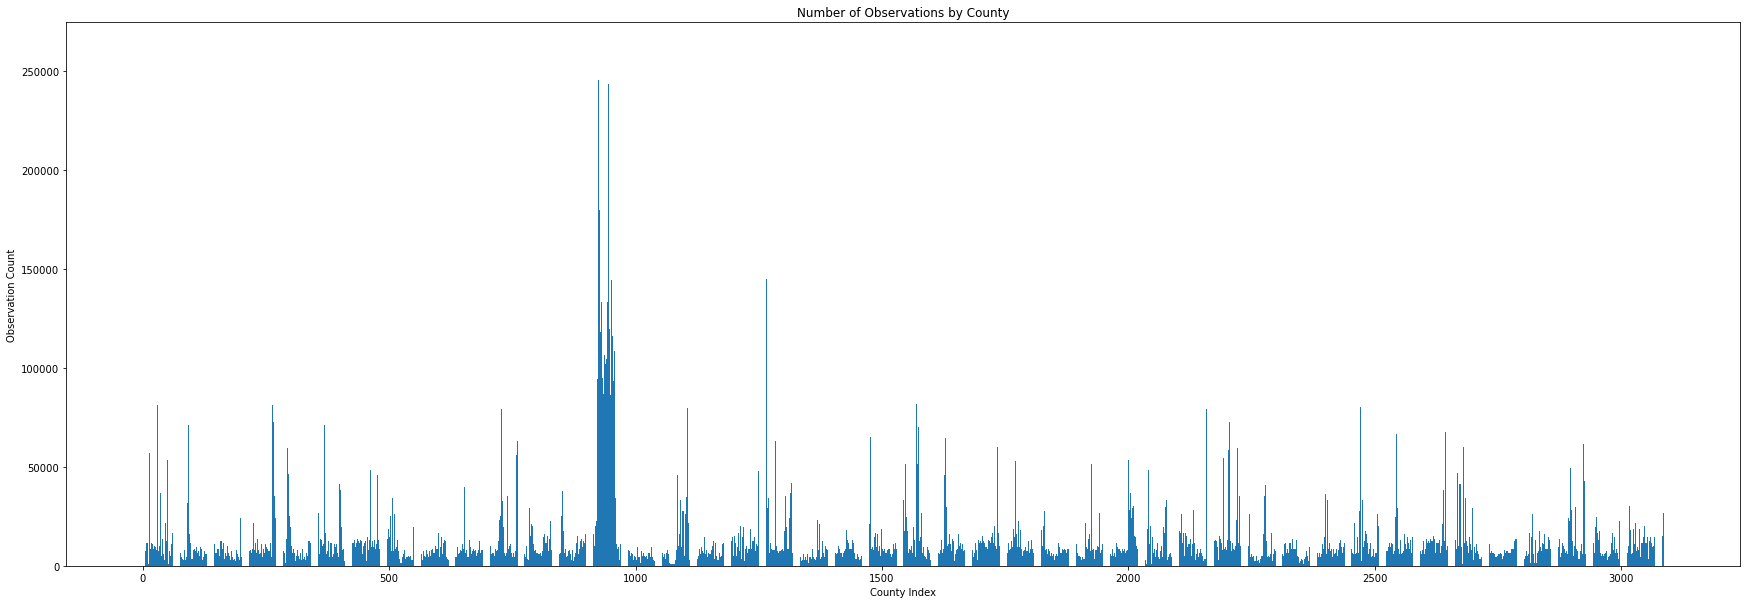

In [14]:
responses = []

for experiment in experiments:
    response_filename = f"{experiment}/response.json"
    with open(response_filename, "r") as response_file:
        responses.append((experiment, json.load(response_file)))

gis_join_count_filename = "../overlay/resources/gis_join_counts.json"

with open(gis_join_count_filename, "r") as f:
    gis_join_counts = json.load(f)

all_worker_counts = []
all_worker_durations = []
all_individual_durations = []
all_losses = []
all_variances = []

for experiment, response in responses:
    print(f"Total response duration for {experiment}: {response['duration_sec']} seconds")

    initial_worker_durations = []
    initial_worker_counts = []
    initial_individual_durations = []
    initial_individual_losses = []
    initial_individual_variances = []

    final_worker_durations = []
    final_worker_counts = []
    final_individual_durations = []
    final_individual_losses = []
    final_individual_variances = []

    for worker_response in response["worker_responses"]:

        worker_durations = initial_worker_durations
        worker_counts = initial_worker_counts
        individual_durations = initial_individual_durations
        individual_losses = initial_individual_losses
        individual_variances = initial_individual_variances

        if "iteration" in worker_response and worker_response["iteration"] == 1:
            worker_durations = final_worker_durations
            worker_counts = final_worker_counts
            individual_durations = final_individual_durations
            individual_losses = final_individual_losses
            individual_variances = final_individual_variances

        worker_durations.append((worker_response["hostname"], worker_response["duration_sec"]))
        worker_counts.append((worker_response["hostname"], len(worker_response["metrics"])))
        for individual_metric in worker_response["metrics"]:
            if "duration_sec" in individual_metric.keys():
                individual_durations.append((individual_metric["gis_join"], individual_metric["duration_sec"]))
                individual_losses.append((individual_metric["gis_join"], individual_metric["loss"]))
                individual_variances.append((individual_metric["gis_join"], individual_metric["variance"]))


    initial_worker_durations.sort(key=lambda y: y[0])
    all_individual_durations.append((experiment, [x[1] for x in initial_individual_durations]))
    initial_individual_losses.sort(key=lambda y: y[0])
    all_losses.append((experiment, [x[1] for x in initial_individual_losses]))
    initial_individual_variances.sort(key=lambda y: y[0])
    all_variances.append((experiment, [x[1] for x in initial_individual_variances]))

    initial_worker_durations.sort(key=lambda y: y[0])
    worker_durations_vals = [x[1] for x in initial_worker_durations]
    worker_durations_names = [x[0][-3:] for x in initial_worker_durations]
    all_worker_durations.append((experiment, worker_durations_names, worker_durations_vals))

    initial_worker_counts.sort(key=lambda y: y[0])
    worker_counts_vals = [x[1] for x in initial_worker_counts]
    worker_counts_names = [x[0][-3:] for x in initial_worker_counts]
    all_worker_counts.append((experiment, worker_counts_names, worker_counts_vals))


# plt.figure(figsize=(7,4), dpi=300)
# worker_counts = all_worker_counts[0]
# plt.bar(np.arange(len(worker_counts[1])), worker_counts[2])
# plt.title("Worker Job Distribution")
# plt.ylabel("Assigned Spatial Extents")
# plt.xlabel("Worker Index")
# plt.show()
#plt.savefig(f"{experiments[0]}/worker_distributions.png", dpi=300)

number_rows = 1
number_cols = 1
#
fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 10))
#fig.tight_layout(h_pad=1.9)
#fig.suptitle("Response/Dataset Statistics", fontsize=40)
bar_width = 1.0/len(experiments) - 0.1
#
# idx = 0
# for worker_durations in all_worker_durations:
#     x_axis = np.arange(len(worker_durations[1]))
#     ax[0].bar(x_axis + idx * bar_width, worker_durations[2], width=bar_width, label=worker_durations[0])
#     idx += 1
# ax[0].set_title(f"Worker Durations")
# ax[0].legend(loc="upper right")
#
# idx = 0
# for worker_counts in all_worker_counts:
#     x_axis = np.arange(len(worker_counts[1]))
#     ax[1].bar(x_axis + idx * bar_width, worker_counts[2], width=bar_width, label=worker_counts[0])
#     idx += 1
# ax[1].set_title(f"Worker Counts")
# ax[1].legend(loc="upper right")
#
ax.set_title(f"Number of Observations by County")
counts = list(gis_join_counts.values())
ax.bar(np.arange(len(counts)), counts)
ax.set_xlabel("County Index")
ax.set_ylabel("Observation Count")
pprint(gis_join_counts.values())
#
# for individual_durations in all_individual_durations:
#     ax[3].plot(individual_durations[1], '.', label=individual_durations[0])
# ax[3].set_title(f"Individual Durations")
# ax[3].legend(loc="upper right")
#
# for individual_losses in all_losses:
#     ax[4].plot(individual_losses[1], '.', label=individual_losses[0])
# ax[4].set_title(f"Individual Losses")
# ax[4].legend(loc="upper right")
#
# for individual_variances in all_variances:
#     ax[5].plot(individual_variances[1], '.', label=individual_variances[0])
# ax[5].set_title(f"Individual Variances")
# ax[5].legend(loc="upper right")
#
# plt.subplots_adjust(top=0.92)
plt.show()
# plt.savefig(f"{experiments[0]}/response_dataset_statistics.png", dpi=300)

### Variance Budget Experiments

In [ ]:
variance_response_filename = "tensorflow/neural_network/variance_budgets/10M_total_500_initial/response.json"
no_budget_response_filename = "tensorflow/neural_network/no_budgets/job_mode_multiprocessing/response.json"
sample_response_filename = "tensorflow/neural_network/static_budgets/sample_rate/20_percent/response.json"
equal_response_filename = "tensorflow/neural_network/static_budgets/total_limit/10M/response.json"
variance_2_response_filename = "tensorflow/neural_network/variance_budgets/10M_total_1000_initial/response.json"
variance_3_response_filename = "tensorflow/neural_network/variance_budgets/10M_total_1000_initial_no_threshold/response.json"

with open(variance_response_filename, "r") as f:
    variance_data = json.load(f)
    
with open(variance_2_response_filename, "r") as f:
    variance_2_data = json.load(f)
    
with open(variance_3_response_filename, "r") as f:
    variance_3_data = json.load(f)

with open(no_budget_response_filename, "r") as f:
    no_budget_data = json.load(f)

with open(sample_response_filename, "r") as f:
    sample_data = json.load(f)

with open(equal_response_filename, "r") as f:
    equal_data = json.load(f)

initial_gis_join_metrics = {}
initial_gis_join_metrics_2 = {}
initial_gis_join_metrics_3 = {}
gis_joins_of_interest = {}
gis_joins_of_interest_2 = {}
gis_joins_of_interest_3 = {}
population_gis_join_metrics = {}
sample_gis_join_metrics = {}
equal_gis_join_metrics = {}
final_gis_join_metrics = {}
final_gis_join_metrics_2 = {}
final_gis_join_metrics_3 = {}

for worker_response in variance_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]

        if "iteration" in metric and metric["iteration"] == 1:
            gis_joins_of_interest[gis_join] = {
                "variance_after": metric["variance"],
                "allocation_after": metric["allocation"],
                "loss_after": metric["loss"]
            }

            final_gis_join_metrics[gis_join]["variance_final"] = metric["variance"]
            final_gis_join_metrics[gis_join]["allocation_final"] = metric["loss"]
            final_gis_join_metrics[gis_join]["loss_final"] = metric["loss"]
        else:
            initial_gis_join_metrics[gis_join] = {
                "variance_before": metric["variance"],
                "allocation_before": metric["allocation"],
                "loss_before": metric["loss"]
            }
            final_gis_join_metrics[gis_join] = {
                "variance_initial": metric["variance"],
                "allocation_initial": metric["allocation"],
                "loss_initial": metric["loss"],
                "variance_final": metric["variance"],
                "allocation_final": metric["allocation"],
                "loss_final": metric["loss"]
            }
            
for worker_response in variance_2_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]

        if "iteration" in metric and metric["iteration"] == 1:
            gis_joins_of_interest_2[gis_join] = {
                "variance_after": metric["variance"],
                "allocation_after": metric["allocation"],
                "loss_after": metric["loss"]
            }

            final_gis_join_metrics_2[gis_join]["variance_final"] = metric["variance"]
            final_gis_join_metrics_2[gis_join]["allocation_final"] = metric["loss"]
            final_gis_join_metrics_2[gis_join]["loss_final"] = metric["loss"]
        else:
            initial_gis_join_metrics_2[gis_join] = {
                "variance_before": metric["variance"],
                "allocation_before": metric["allocation"],
                "loss_before": metric["loss"]
            }
            final_gis_join_metrics_2[gis_join] = {
                "variance_initial": metric["variance"],
                "allocation_initial": metric["allocation"],
                "loss_initial": metric["loss"],
                "variance_final": metric["variance"],
                "allocation_final": metric["allocation"],
                "loss_final": metric["loss"]
            }
            
for worker_response in variance_3_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]

        if "iteration" in metric and metric["iteration"] == 1:
            gis_joins_of_interest_3[gis_join] = {
                "variance_after": metric["variance"],
                "allocation_after": metric["allocation"],
                "loss_after": metric["loss"]
            }

            final_gis_join_metrics_3[gis_join]["variance_final"] = metric["variance"]
            final_gis_join_metrics_3[gis_join]["allocation_final"] = metric["loss"]
            final_gis_join_metrics_3[gis_join]["loss_final"] = metric["loss"]
        else:
            initial_gis_join_metrics_3[gis_join] = {
                "variance_before": metric["variance"],
                "allocation_before": metric["allocation"],
                "loss_before": metric["loss"]
            }
            final_gis_join_metrics_3[gis_join] = {
                "variance_initial": metric["variance"],
                "allocation_initial": metric["allocation"],
                "loss_initial": metric["loss"],
                "variance_final": metric["variance"],
                "allocation_final": metric["allocation"],
                "loss_final": metric["loss"]
            }


for worker_response in no_budget_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]
        population_gis_join_metrics[gis_join] = {
            "population_variance": metric["variance"],
            "population_allocation": metric["allocation"],
            "population_loss": metric["loss"]
        }

for worker_response in sample_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]
        sample_gis_join_metrics[gis_join] = {
            "sample_variance": metric["variance"],
            "sample_allocation": metric["allocation"],
            "sample_loss": metric["loss"]
        }

for worker_response in equal_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        gis_join = metric["gis_join"]
        equal_gis_join_metrics[gis_join] = {
            "equal_variance": metric["variance"],
            "equal_allocation": metric["allocation"],
            "equal_loss": metric["loss"]
        }

for gis_join, metric in gis_joins_of_interest.items():
    initial_metric = initial_gis_join_metrics[gis_join]
    metric["variance_before"] = initial_metric["variance_before"]
    metric["allocation_before"] = initial_metric["allocation_before"]
    metric["loss_before"] = initial_metric["loss_before"]

    population_metric = population_gis_join_metrics[gis_join]
    metric["variance_population"] = population_metric["population_variance"]
    metric["allocation_population"] = population_metric["population_allocation"]
    metric["loss_population"] = population_metric["population_loss"]

    sample_metric = sample_gis_join_metrics[gis_join]
    metric["variance_sample"] = sample_metric["sample_variance"]
    metric["allocation_sample"] = sample_metric["sample_allocation"]
    metric["loss_sample"] = sample_metric["sample_loss"]

    equal_metric = equal_gis_join_metrics[gis_join]
    metric["variance_equal"] = equal_metric["equal_variance"]
    metric["allocation_equal"] = equal_metric["equal_allocation"]
    metric["loss_equal"] = equal_metric["equal_loss"]

for gis_join, metric in final_gis_join_metrics.items():
    final_gis_join_metrics[gis_join]["variance_pop"] = population_gis_join_metrics[gis_join]["population_variance"]
    final_gis_join_metrics[gis_join]["allocation_pop"] = population_gis_join_metrics[gis_join]["population_allocation"]
    final_gis_join_metrics[gis_join]["loss_pop"] = population_gis_join_metrics[gis_join]["population_loss"]
    final_gis_join_metrics[gis_join]["variance_sample"] = sample_gis_join_metrics[gis_join]["sample_variance"]
    final_gis_join_metrics[gis_join]["allocation_sample"] = sample_gis_join_metrics[gis_join]["sample_allocation"]
    final_gis_join_metrics[gis_join]["loss_sample"] = sample_gis_join_metrics[gis_join]["sample_loss"]
    final_gis_join_metrics[gis_join]["variance_equal"] = equal_gis_join_metrics[gis_join]["equal_variance"]
    final_gis_join_metrics[gis_join]["allocation_equal"] = equal_gis_join_metrics[gis_join]["equal_allocation"]
    final_gis_join_metrics[gis_join]["loss_equal"] = equal_gis_join_metrics[gis_join]["equal_loss"]
    
for gis_join, metric in final_gis_join_metrics_2.items():
    final_gis_join_metrics_2[gis_join]["variance_pop"] = population_gis_join_metrics[gis_join]["population_variance"]
    final_gis_join_metrics_2[gis_join]["allocation_pop"] = population_gis_join_metrics[gis_join]["population_allocation"]
    final_gis_join_metrics_2[gis_join]["loss_pop"] = population_gis_join_metrics[gis_join]["population_loss"]
    final_gis_join_metrics_2[gis_join]["variance_sample"] = sample_gis_join_metrics[gis_join]["sample_variance"]
    final_gis_join_metrics_2[gis_join]["allocation_sample"] = sample_gis_join_metrics[gis_join]["sample_allocation"]
    final_gis_join_metrics_2[gis_join]["loss_sample"] = sample_gis_join_metrics[gis_join]["sample_loss"]
    final_gis_join_metrics_2[gis_join]["variance_equal"] = equal_gis_join_metrics[gis_join]["equal_variance"]
    final_gis_join_metrics_2[gis_join]["allocation_equal"] = equal_gis_join_metrics[gis_join]["equal_allocation"]
    final_gis_join_metrics_2[gis_join]["loss_equal"] = equal_gis_join_metrics[gis_join]["equal_loss"]
    
for gis_join, metric in final_gis_join_metrics_3.items():
    final_gis_join_metrics_3[gis_join]["variance_pop"] = population_gis_join_metrics[gis_join]["population_variance"]
    final_gis_join_metrics_3[gis_join]["allocation_pop"] = population_gis_join_metrics[gis_join]["population_allocation"]
    final_gis_join_metrics_3[gis_join]["loss_pop"] = population_gis_join_metrics[gis_join]["population_loss"]
    final_gis_join_metrics_3[gis_join]["variance_sample"] = sample_gis_join_metrics[gis_join]["sample_variance"]
    final_gis_join_metrics_3[gis_join]["allocation_sample"] = sample_gis_join_metrics[gis_join]["sample_allocation"]
    final_gis_join_metrics_3[gis_join]["loss_sample"] = sample_gis_join_metrics[gis_join]["sample_loss"]
    final_gis_join_metrics_3[gis_join]["variance_equal"] = equal_gis_join_metrics[gis_join]["equal_variance"]
    final_gis_join_metrics_3[gis_join]["allocation_equal"] = equal_gis_join_metrics[gis_join]["equal_allocation"]
    final_gis_join_metrics_3[gis_join]["loss_equal"] = equal_gis_join_metrics[gis_join]["equal_loss"]

total_list = list(final_gis_join_metrics.values())
total_list.sort(key=lambda m: m["variance_pop"], reverse=True)
total_list_2 = list(final_gis_join_metrics_2.values())
total_list_2.sort(key=lambda m: m["variance_pop"], reverse=True)
total_list_3 = list(final_gis_join_metrics_3.values())
total_list_3.sort(key=lambda m: m["variance_pop"], reverse=True)
#total_list = total_list[:250]

as_updated_list = list(gis_joins_of_interest.values())
as_updated_list.sort(key=lambda m: m["variance_population"], reverse=True)

all_variances_before = [m["variance_initial"] for m in total_list]
all_variances_after = [m["variance_final"] for m in total_list]
all_variances_pop = [m["variance_pop"] for m in total_list]
all_variances_sample = [m["variance_sample"] for m in total_list]
all_variances_equal = [m["variance_equal"] for m in total_list]

interest_variances_before = [m["variance_before"] for m in as_updated_list]
interest_variances_after = [m["variance_after"] for m in as_updated_list]
interest_variances_pop = [m["variance_population"] for m in as_updated_list]
interest_variances_sample = [m["variance_sample"] for m in as_updated_list]
interest_variances_equal = [m["variance_equal"] for m in as_updated_list]

number_rows = 2
number_cols = 2

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(10,10), dpi=300)
#fig.tight_layout(h_pad=1.9)

# --- Plot variances ---

# Uncomment to plot only the GISJOINs that were run through a second pass
ax[0][0].plot(interest_variances_pop, '-', ms=4, lw=2, label="Population Variances", color=CB_color_cycle['blue'])
ax[0][0].plot(interest_variances_before, '+', ms=4, lw=1, label="Var. Budget Initial Variances", color=CB_color_cycle['gray'])
ax[0][0].plot(interest_variances_after, '.', ms=4, lw=1, label="Var. Budget Final Variances", color=CB_color_cycle['orange'])
ax[1][0].plot(interest_variances_pop, '-', ms=4, lw=2, label="Population Variances", color=CB_color_cycle['blue'])
ax[1][0].plot(interest_variances_equal, '+', ms=4, lw=1, label="Equal Alloc. Budget Variances", color=CB_color_cycle['purple'])
ax[1][0].plot(interest_variances_sample, '.', ms=4, lw=1, label="Prop. Sample Budget Variances", color=CB_color_cycle['pink'])


# Uncomment to plot all GISJOINs
# ax[0][0].plot(all_variances_before, '-', ms=4, label="Variances Before")
# ax[0][0].plot(all_variances_sample, '-', ms=4, label="Variances Sample")
# ax[0][0].plot(all_variances_after, '-', ms=4, label="Variances After")
# ax[0][0].plot(all_variances_sample, '-', ms=4, label="Population Variances")
# ax[0][0].plot(all_variances_equal, '-', ms=4, label="Variances Equal")


#ax[0].plot(initial_losses, final_losses, '.', label="Losses")  # plot initial against final losses

as_updated_list.sort(key=lambda m: m["loss_population"], reverse=True)
total_list.sort(key=lambda m: m["loss_pop"], reverse=True)

all_losses_before = [m["loss_initial"] for m in total_list]
all_losses_after = [m["loss_final"] for m in total_list]
all_losses_pop = [m["loss_pop"] for m in total_list]
all_losses_sample = [m["loss_sample"] for m in total_list]
all_losses_equal = [m["loss_equal"] for m in total_list]

interest_losses_before = [m["loss_before"] for m in as_updated_list]
interest_losses_after = [m["loss_after"] for m in as_updated_list]
interest_losses_pop = [m["loss_population"] for m in as_updated_list]
interest_losses_equal = [m["loss_equal"] for m in as_updated_list]
interest_losses_sample = [m["loss_sample"] for m in as_updated_list]

# --- Plot losses ---


# Uncomment to plot only the GISJOINs that were run through a second pass
ax[0][1].plot(interest_losses_pop, '-', ms=4, lw=2, label="Population Losses", color=CB_color_cycle['blue'])
ax[0][1].plot(interest_losses_before, '+', ms=4, lw=1, label="Var. Budget Initial Losses", color=CB_color_cycle['gray'])
ax[0][1].plot(interest_losses_after, '.', ms=4, lw=1, label="Var. Budget Final Losses", color=CB_color_cycle['orange'])
ax[1][1].plot(interest_losses_pop, '-', ms=4, lw=2, label="Population Losses", color=CB_color_cycle['blue'])
ax[1][1].plot(interest_losses_equal, '+', ms=4, lw=1, label="Equal Alloc. Budget Losses", color=CB_color_cycle['purple'])
ax[1][1].plot(interest_losses_sample, '.', ms=4, lw=1, label="Prop. Sample Budget Losses", color=CB_color_cycle['pink'])

# Uncomment to plot all GISJOINs
# ax[1].plot(all_losses_before, '-', ms=4, label="Losses Before")
# ax[1].plot(all_losses_after, '-', ms=4, label="Losses After")
# ax[1].plot(all_losses_pop, '-', ms=4, label="Population Losses")
# ax[1].plot(all_losses_equal, '-', ms=4, label="Losses Equal")
# ax[1].plot(all_losses_sample, '-', ms=4, label="Losses Sample")


ax[0][0].set_title("Pop. Variance Estimates")
ax[0][0].set_ylabel("Variance")
ax[0][1].set_ylabel("Loss")
ax[1][0].set_xlabel("County Index")
ax[0][1].set_title("Pop. Loss Estimates")
ax[1][0].set_ylabel("Variance")
ax[1][1].set_ylabel("Loss")
ax[1][1].set_xlabel("County Index")

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()

plt.show()
#plt.savefig("tensorflow/neural_network/variance_budgets/10M_total_500_initial/loss_variance_estimates_by_budget.png", dpi=300)

# varying_losses = []
# for metric in as_list:
#     #print(f"GISJOIN: {metric['gis_join']}, Difference: {abs(metric['initial_loss'] - metric['final_loss'])}")
#     varying_losses.append((metric["gis_join"], abs(metric['initial_loss'] - metric['final_loss'])))
#
# varying_losses.sort(key=lambda y: y[1], reverse=True)

In [ ]:

total_list.sort(key=lambda m: m["variance_pop"], reverse=True)


all_variances_before = [m["variance_initial"] for m in total_list]
all_variances_after = [m["variance_final"] for m in total_list]
all_variances_pop = [m["variance_pop"] for m in total_list]
all_variances_sample = [m["variance_sample"] for m in total_list]
all_variances_equal = [m["variance_equal"] for m in total_list]

all_variances_before_2 = [m["variance_initial"] for m in total_list_2]
all_variances_after_2 = [m["variance_final"] for m in total_list_2]
all_variances_pop_2 = [m["variance_pop"] for m in total_list_2]
all_variances_sample_2 = [m["variance_sample"] for m in total_list_2]
all_variances_equal_2 = [m["variance_equal"] for m in total_list_2]

all_variances_before_3 = [m["variance_initial"] for m in total_list_3]
all_variances_after_3 = [m["variance_final"] for m in total_list_3]
all_variances_pop_3 = [m["variance_pop"] for m in total_list_3]
all_variances_sample_3 = [m["variance_sample"] for m in total_list_3]
all_variances_equal_3 = [m["variance_equal"] for m in total_list_3]

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(7,8), dpi=300)
fig.subplots_adjust(hspace=0.1)
fig.suptitle("Variance Estimate Budget Comparison")

ax[0].plot(all_variances_after, '.', ms=2, lw=2, label="Variance Budget, 10M/500/2.0", color=CB_color_cycle['orange'])
ax[0].plot(all_variances_pop, '-', ms=4, lw=1, label="Population Variances", color=CB_color_cycle['blue'])
ax[0].set_xticks([])
ax[0].legend()
#ax[0].plot(all_variances_after, '-', ms=4, lw=2, label="Variance Budget After")
# ax[0].plot(all_variances_pop, '-', ms=4, label="Variances Before")


ax[1].plot(all_variances_after_2, '.', ms=2, lw=2, label="Variance Budget, 10M/1000/1.0", color=CB_color_cycle['orange'])
ax[1].plot(all_variances_pop_2, '-', ms=2, lw=1, color=CB_color_cycle['blue'])
ax[1].set_xticks([])
ax[1].legend()

ax[2].plot(all_variances_after_3, '.', ms=2, lw=2, label="Variance Budget, 10M/1000/None", color=CB_color_cycle['orange'])
ax[2].plot(all_variances_pop, '-', ms=2, lw=1, color=CB_color_cycle['blue'])
ax[2].set_xticks([])
ax[2].legend()

ax[3].plot(all_variances_sample_2, '.', ms=2, lw=2, label="Sample Budget, 20%", color=CB_color_cycle['orange'])
ax[3].plot(all_variances_pop, '-', ms=4, lw=1, color=CB_color_cycle['blue'])
ax[3].set_xticks([])
ax[3].legend()

ax[4].plot(all_variances_equal, '.', ms=2, lw=2, label="Equal Allocation Budget, 10M", color=CB_color_cycle['orange'])
ax[4].plot(all_variances_pop, '-', ms=4, lw=1, color=CB_color_cycle['blue'])
ax[4].legend()
# ax[0].plot(all_variances_after, '-', ms=4, label="Variances After")
# ax[0].plot(all_variances_sample, '-', ms=4, label="Population Variances")
# ax[0].plot(all_variances_equal, '-', ms=4, label="Variances Equal")

plt.show()
#plt.savefig("tensorflow/neural_network/variance_budgets/10M_total_1000_initial/loss_variance_estimates_by_budget.png", dpi=300)




In [ ]:
with open("tensorflow/neural_network/variance_budgets/10M_total_500_initial/numpy_array.json", "r") as f:
    std_devs = json.load(f)
    
std_devs_np = np.sort(np.abs(np.array(std_devs)))[::-1]

plt.figure(figsize=(7,4), dpi=300)
plt.plot(std_devs_np, label="County Standard Deviations")

plt.bar(range(120), std_devs_np[:120], width=0.5, color=CB_color_cycle['orange'])
plt.bar(range(120,3088), std_devs_np[120:], width=0.5, color=CB_color_cycle['gray'])
plt.axhline(y=2, color='r', lw=1, label="Threshold Cutoff")
plt.ylabel("Abs. Std. Dev. from Mean")
plt.xlabel("County Index")
plt.legend()
plt.title("Sorted Variance Estimates in Standard Deviations from Mean")
#plt.savefig("tensorflow/neural_network/variance_budgets/10M_total_500_initial/variance_std_devs_threshold.png", dpi=300)
plt.show()

### Job Durations by Processing Mode

In [ ]:
with open("tensorflow/neural_network/no_budgets/job_mode_multiprocessing/response.json", "r") as f:
    multiprocessing = json.load(f)

with open("tensorflow/neural_network/no_budgets/job_mode_multithreaded/response.json", "r") as f:
    multithreaded = json.load(f)

with open("tensorflow/neural_network/no_budgets/job_mode_synchronous/response.json", "r") as f:
    synchronous = json.load(f)

synchronous_workers = [x["duration_sec"] for x in synchronous["worker_responses"]]
multithreaded_workers = [x["duration_sec"] for x in multithreaded["worker_responses"]]
multiprocessing_workers = [x["duration_sec"] for x in multiprocessing["worker_responses"]]

fig, ax1 = plt.subplots(figsize=(7,4), dpi=300)
ax1.bar([1,2,3], [synchronous["duration_sec"],  multithreaded["duration_sec"], multiprocessing["duration_sec"]], width=0.5, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2 = ax1.twinx()
bp = ax1.boxplot([synchronous_workers, multithreaded_workers, multiprocessing_workers], patch_artist=False)

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='k',
            linewidth = 1,
            alpha = 0.5)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='k',
               linewidth = 1,
               alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='k',
              alpha = 0.5)


xtick_labels = ["Synchronous", "Multithreaded", "Multiprocessing"]
ax1.set_xticklabels(xtick_labels)
ax2.set_yticks([])

ax1.set_ylabel("Duration Sec")
ax1.set_xlabel("Processing Mode")
plt.title("Job Durations by Processing Mode")
#plt.savefig("tensorflow/neural_network/no_budgets/job_durations.png", dpi=300)

### Job Durations by Budget Type

In [ ]:
with open("tensorflow/neural_network/no_budgets/job_mode_multiprocessing/response.json", "r") as f:
    no_budgets = json.load(f)

with open("tensorflow/neural_network/static_budgets/sample_rate/20_percent/response.json", "r") as f:
    sample_rate_20 = json.load(f)

with open("tensorflow/neural_network/static_budgets/total_limit/10M/response.json", "r") as f:
    equal_10 = json.load(f)

with open("tensorflow/neural_network/variance_budgets/10M_total_1000_initial/response.json", "r") as f:
    variance_all = json.load(f)

all_durations = {}  # worker -> duration_sec
for worker_response in variance_all["worker_responses"]:
    if worker_response["hostname"] not in all_durations:
        all_durations[worker_response["hostname"]] = worker_response["duration_sec"]
    else:
        all_durations[worker_response["hostname"]] += worker_response["duration_sec"]

no_budgets_workers = [x["duration_sec"] for x in no_budgets["worker_responses"]]
sample_rate_20_workers = [x["duration_sec"] for x in sample_rate_20["worker_responses"]]
equal_10_workers = [x["duration_sec"] for x in equal_10["worker_responses"]]
variance_added_workers = list(all_durations.values())

fig, ax1 = plt.subplots(figsize=(7,4), dpi=300)
ax1.bar([1,2,3,4], [no_budgets["duration_sec"],  sample_rate_20["duration_sec"], equal_10["duration_sec"], variance_all["duration_sec"]],
        width=0.5, color=[CB_color_cycle['blue'], CB_color_cycle['orange'], CB_color_cycle['gray'], CB_color_cycle['green']])
ax2 = ax1.twinx()
bp = ax1.boxplot([no_budgets_workers, sample_rate_20_workers, equal_10_workers, variance_added_workers], patch_artist=False)

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='k',
            linewidth = 1,
            alpha = 0.5)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='k',
               linewidth = 1,
               alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='k',
              alpha = 0.5)


xtick_labels = ["No Budget", "Sample 20%", "Equal 10M", "Variance 10M"]
ax1.set_xticklabels(xtick_labels)
ax2.set_yticks([])

ax1.set_ylabel("Duration Sec")
ax1.set_xlabel("Budget Type")
plt.title("Job Durations by Budget Types")
plt.show()
#plt.savefig("tensorflow/neural_network/variance_budgets/10M_total_500_initial/job_durations_by_budget_type.png", dpi=300)